In this notebook, we will be building our model for the closed-world experiments to classify 95 monitored websites

# Extracting Data

To begin, we will first import the dataframes into this notebook

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

**Only use one of the next 2 blocks**

In [ ]:
# 1 Use this with colab
print("Loading datafile...")
with open('datasets/extracted_features.pkl', 'rb') as f:
    df = pickle.load(f)
print ("Data loaded")

Loading datafile...


In [ ]:
# 2 Use this for local (change the directory to where the extracted_features.pkl is stored on your local machine)
# Load the pickle file
print("Loading datafile...")
# chance this directory to the directory where mon_standard.pkl is stored on your local machine
file_path = r'C:\EWHA\Term 2\Machine Learning\pro\neurotic_networkers\extracted_features.pkl' # Jordans local path
with open(file_path, 'rb') as f: # Path to extracted_features.pkl in Colab
    df = pickle.load(f)
print ("Data loaded")

Loading datafile...
Data loaded


In [26]:
df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In this notebook, since we will only be dealing with the closed world experiments, we will first extract the relevant data from the dataframe

In [27]:
closed_world_df = df[df['label'] != -1]

In [28]:
closed_world_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
18995,94,8815,619,9434,0.934386,0.065614,3053.116218,4844.586430,43.91,0.004654
18996,94,9404,552,9956,0.944556,0.055444,3010.091146,4541.974638,15.60,0.001567
18997,94,9373,579,9952,0.941821,0.058179,3102.381602,4766.072539,14.93,0.001500
18998,94,9236,690,9926,0.930486,0.069514,3116.574388,5278.146377,19.91,0.002006


# Constructing Model

In [ ]:
# Separate features and target labels
X = closed_world_df.drop(columns=['label'])
y = closed_world_df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets successfully.")

# Normalize the data using the provided StandardScaler function
def scaler_samples(train_X,test_X):
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    return train_X, test_X

print("Data normalized successfully.") 


Data split into training and testing sets successfully.
Data normalized successfully.


In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy and other metrics
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)

Model Accuracy: 0.7257894736842105
              precision    recall  f1-score   support

           0       0.74      0.69      0.72        42
           1       0.58      0.36      0.44        42
           2       0.70      0.89      0.78        35
           3       0.69      0.83      0.75        29
           4       0.70      0.90      0.79        39
           5       0.81      0.93      0.87        45
           6       0.73      0.86      0.79        44
           7       0.68      0.64      0.66        36
           8       0.65      0.71      0.68        34
           9       0.64      0.68      0.66        31
          10       0.84      0.66      0.74        47
          11       0.67      0.74      0.70        35
          12       0.88      0.90      0.89        42
          13       0.53      0.50      0.51        40
          14       0.64      0.50      0.56        36
          15       0.76      0.74      0.75        35
          16       0.80      0.65      0.72   

# Feature Importance

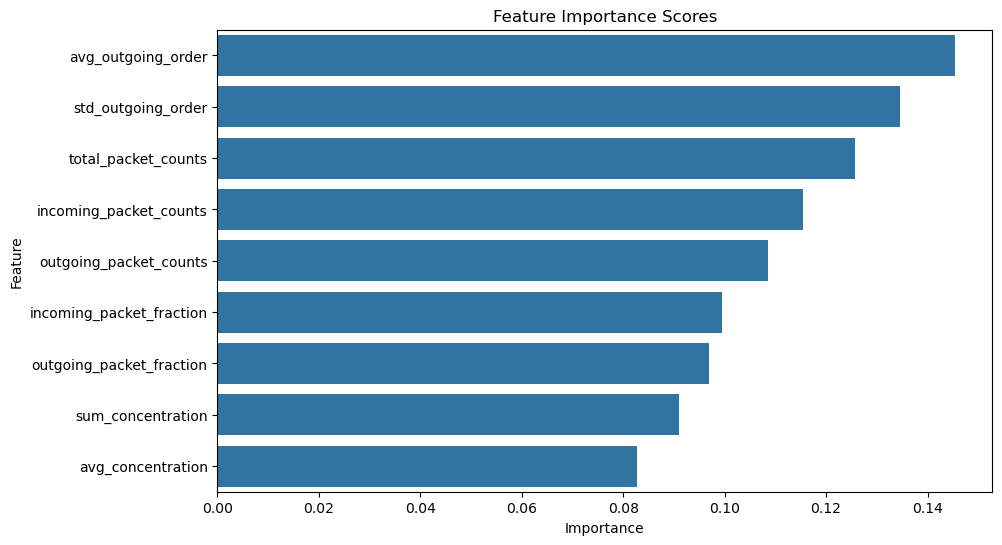

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance Scores')
plt.show()


# Model Tuning

In [ ]:
# I'm using this RandomizedSearchCV example to make sure its running within a reasonable time frame

# Define a smaller parameter grid
param_grid = {
    'n_estimators': [100, 150],  # Fewer options
    'max_depth': [None, 10],  # Simplified depth 
    'min_samples_split': [2, 5],  # Reduced range
    'min_samples_leaf': [1, 2]  # Reduced range
}

# Set up Randomized Search with fewer iterations and 3-fold CV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Limit the number of combinations checked
    cv=3,  # Fewer cross-validation folds
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Fit the search to the training data
random_search.fit(X_train, y_train)

# Best parameters from the search
print("Best parameters found:", random_search.best_params_)

# Evaluate with the best estimator
best_rf_model = random_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best parameters found: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Optimized Model Accuracy: 0.7260526315789474
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        42
           1       0.64      0.33      0.44        42
           2       0.74      0.89      0.81        35
           3       0.69      0.83      0.75        29
           4       0.68      0.87      0.76        39
           5       0.82      0.93      0.88        45
           6       0.75      0.86      0.80        44
           7       0.70      0.64      0.67        36
           8       0.63      0.71      0.67        34
           9       0.62      0.65      0.63        31
          10       0.87      0.70      0.78        47
          11       0.68      0.74      0.71        35
          12       0.88      0.90      0.89        42
          13       0.50      0.50      0.50        40
          14       0.62      0.50

In [ ]:
# I was able to run this in a reasonable time frame (under 12 minutes)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best parameters found:", grid_search.best_params_)

# Evaluate with the best estimator
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Print metrics
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Optimized Model Accuracy: 0.7297368421052631

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        42
           1       0.61      0.33      0.43        42
           2       0.78      0.89      0.83        35
           3       0.69      0.86      0.77        29
           4       0.68      0.87      0.76        39
           5       0.78      0.93      0.85        45
           6       0.73      0.86      0.79        44
           7       0.71      0.69      0.70        36
           8       0.63      0.71      0.67        34
           9       0.60      0.68      0.64        31
          10       0.89      0.68      0.77        47
          11       0.65      0.74      0.69        35
          12       0.84      0.90      0.87        42
          13       0.50      0.50      0.50        40
        